Serial Bias
===========



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../')

import torch
from time import perf_counter

from src.network import Network
from src.plasticity import Plasticity
from src.decode import decode_bump

REPO_ROOT = '/home/leon/models/NeuroTorch/'

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Single Trial



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr', LIVE_FF_UPDATE=1)
rates = model().cpu().detach().numpy()

tensor([[0.0000e+00, 1.4901e-07, 6.2585e-07,  ..., 1.4007e-06, 6.2585e-07,
         1.4901e-07]], device='cuda:0')
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]],
       device='cuda:0')
tensor([[0.5000, 0.5004, 0.5008,  ..., 0.4988, 0.4992, 0.4996]],
       device='cuda:0')

In [1]:
print(model.PHI0.shape)

torch.Size([1, 3])

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

# [goto error]
#+begin_example
  ---------------------------------------------------------------------------
  AttributeError                            Traceback (most recent call last)
  Cell In[6], line 1
  ----> 1 u_list = model.u_list.cpu().numpy()
        2 x_list = model.x_list.cpu().numpy()
        3 print(u_list.shape, x_list.shape)

  File ~/mambaforge/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:1688, in Module.__getattr__(self, name)
     1686     if name in modules:
     1687         return modules[name]
  -> 1688 raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

  AttributeError: 'Network' object has no attribute 'u_list'
#+end_example

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[7], line 8
      5 ax[0].set_xlabel('$Step$')
      6 ax[0].set_ylabel('Rates')
----> 8 ax[1].plot(u_list.mean(-1).T, 'k')
      9 ax[1].plot(u_list[0, :, :10], alpha=.25)
     10 ax[1].set_xlabel('Step')

NameError: name 'u_list' is not defined

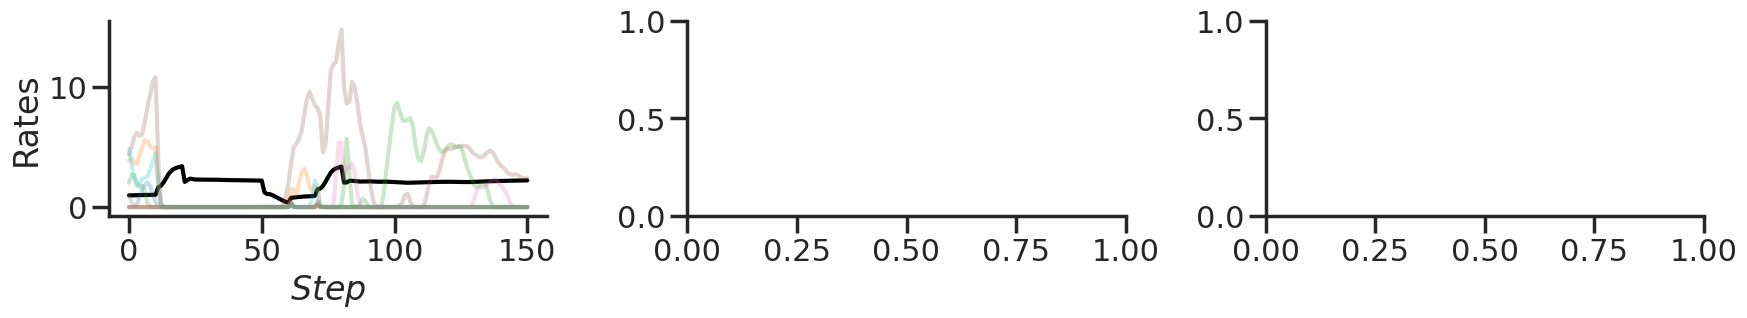

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[3*width, height])

ax[0].plot(rates.mean(-1).T, 'k')
ax[0].plot(rates[0, :, :10], alpha=.25)
ax[0].set_xlabel('$Step$')
ax[0].set_ylabel('Rates')

ax[1].plot(u_list.mean(-1).T, 'k')
ax[1].plot(u_list[0, :, :10], alpha=.25)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$u$')

ax[2].plot(x_list.mean(-1).T, 'k')
ax[2].plot(x_list[0, :, :10], alpha=.25)
ax[2].set_xlabel('Step')
ax[2].set_ylabel('$x$')

plt.show()

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(1, 151)

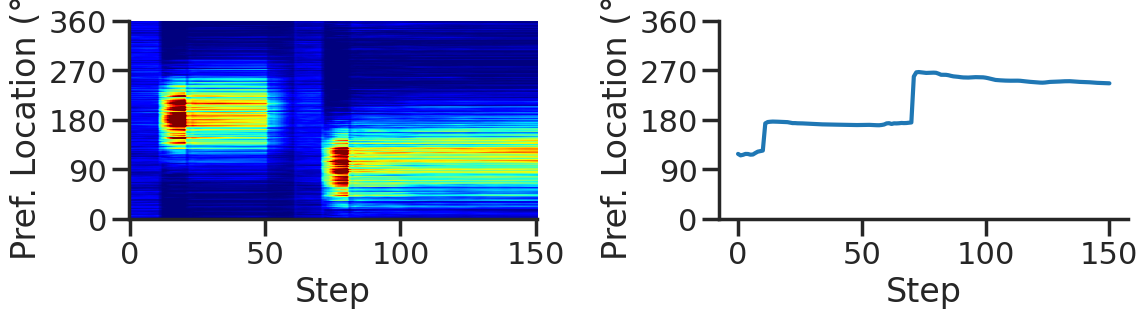

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(rates.T, aspect='auto', cmap='jet', vmin=0, vmax=10, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi[0] * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

## Serial Bias



### Batching Inputs Sequences



In [1]:
N_PHASE = 2
PHI0_list = np.linspace(180, 360, N_PHASE)

model.N_BATCH = N_PHASE
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr', seed=1)

ff_input = []
for i in PHI0_list:
    model.PHI0[:, -1] = i  # here we set the ff input to E to value i in 0 .. 10
    ff_input.append(model.init_ff_input())

ff_input = torch.vstack(ff_input)
print('ff_inputs', ff_input.shape)

ff_inputs torch.Size([2, 12100, 10000])

In [1]:
rates = model(ff_input=ff_input, RET_FF=1).cpu().detach().numpy()
print(rates.shape)

(2, 111, 8000)

In [1]:
ff_input = model.ff_input.cpu().numpy()
print(ff_input.shape)

(2, 12100, 8000)

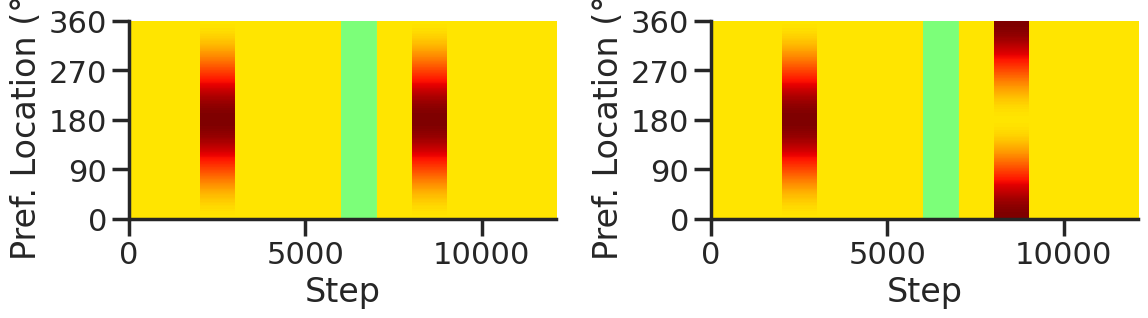

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(ff_input[0].T, aspect='auto', cmap='jet', vmin=0, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].imshow(ff_input[1].T, aspect='auto', cmap='jet', vmin=0, origin='lower')
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[1].set_xlabel('Step')

plt.show()

In [1]:
ff_input[0,:,0]

array([44.72136, 44.72136, 44.72136, ..., 44.72136, 44.72136, 44.72136],
      dtype=float32)

### Batching Live Inputs



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr', seed=1, LIVE_FF_UPDATE=1)

#########################################################################################################
### WARNING ### YOU NEED TO SET LIVE_FF_UPDATE INSIDE THE MODEL DEF OTHERWISE Ja0 WONT BE SCALED PROPERLY
#########################################################################################################

N_PHASE = 32
print(model.PHI0.shape)

PHI0 = model.PHI0.unsqueeze(-1).repeat((N_PHASE, 1, 1))

print(PHI0.shape)
PHI0[:, -1] = torch.linspace(45, 360, N_PHASE).unsqueeze(1)
# print(PHI0[:, :, 0])

torch.Size([1, 3])
torch.Size([32, 3, 1])

In [1]:
model.PHI0 = PHI0
model.N_BATCH = N_PHASE
rates = model(RET_FF=0).cpu().numpy()
print(rates.shape)

(32, 111, 8000)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(32, 111)

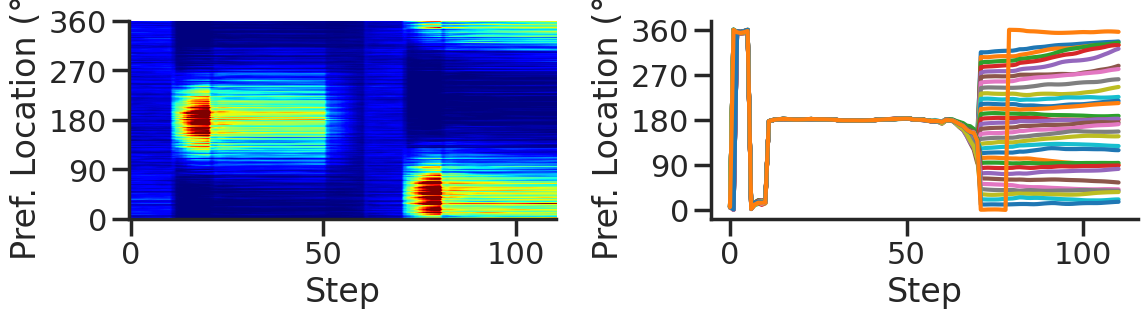

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=10, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi.T * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

In [1]:
rel_loc = (model.PHI0[:, 0] - model.PHI0[:, -1]).cpu().numpy()
errors = model.PHI0[:, -1].cpu().numpy() - (360 - phi * 180 / np.pi)

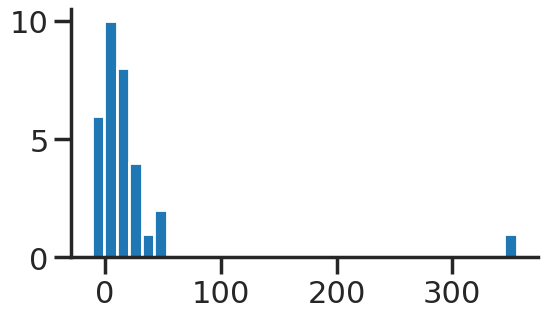

In [1]:
plt.hist(errors[:, -1], bins='auto')
plt.show()

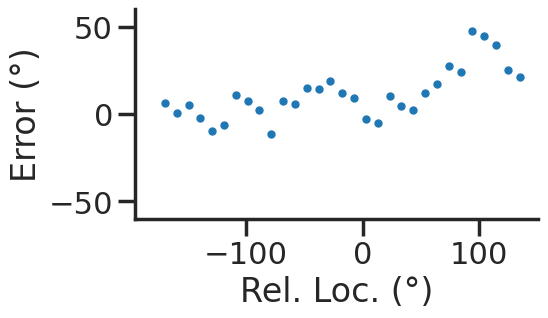

In [1]:
plt.plot(rel_loc[:, 0], errors[:,-1], 'o')
plt.xlabel('Rel. Loc. (°)')
plt.ylabel('Error (°)')
plt.ylim([-60, 60])
plt.show()